In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
import datetime as dt
import copy

pd.options.mode.chained_assignment = None  # default='warn'

/Users/fqian/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn import svm
import sklearn.neural_network

## 1. Data Cleaning and Feature Engineering

#### 1.1 First clean: only take the useful columns

In [3]:
round5 = pd.read_json("round5_merged.json")
round4 = pd.read_json("round4_merged.json")
round3 = pd.read_json("round3_merged.json")
round2 = pd.read_json("round2_merged.json")
round1 = pd.read_json("round1_merged.json")
sent_info = pd.read_json("sent_info.json")

In [4]:
round5.columns

Index([u'Unnamed: 0', u'account', u'actions', u'availability', u'beds',
       u'bucket_name', u'calendars', u'decision', u'discount_agreed',
       u'discount_asked', u'discount_obtained', u'extra_people',
       u'guests_included', u'host_acceptance_rate', u'host_id',
       u'host_is_superhost', u'host_name', u'host_response_rate',
       u'host_response_time', u'host_total_listings_count', u'host_url', u'id',
       u'instant_bookable', u'listing_url', u'minimum_nights',
       u'monthly_price', u'nightly_plus_guest_price_x',
       u'nightly_plus_guest_price_y', u'nightly_price',
       u'nightly_price_scraped', u'number_of_reviews', u'openings',
       u'percent_agreed', u'price_agreed', u'price_requested', u'response',
       u'room_type'],
      dtype='object')

In [5]:
round5_clean = round5[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested", "beds", "number_of_reviews"]]
round4_clean = round4[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount", "percent_agreed",
                       "calendars", "price_requested", "beds", "number_of_reviews"]]
round3_clean = round3[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested", "beds", "number_of_reviews"]]
round2_clean = round2[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "decision", "price_agreed", "discount_agreed", "percent_agreed",
                       "calendars", "price_requested", "beds", "number_of_reviews"]]
round1_clean = round1[["id", "host_id", "host_response_rate", "host_acceptance_rate", 
                       "host_total_listings_count", "instant_bookable", 
                       "room_type", "bucket_name", "discount_asked", "nightly_price", 
                       "availability", "price", "discount",
                       "calendars", "price_requested", "beds", "number_of_reviews"]]

print "Number of observations in round 5: ", len(round5_clean)
print "Number of observations in round 4: ", len(round4_clean)
print "Number of observations in round 3: ", len(round3_clean)
print "Number of observations in round 2: ", len(round2_clean)
print "Number of observations in round 1: ", len(round1_clean)

# round3_clean.reset_index(drop=True).head()

Number of observations in round 5:  279
Number of observations in round 4:  281
Number of observations in round 3:  288
Number of observations in round 2:  226
Number of observations in round 1:  194


In [6]:
round1_clean = round1_clean.rename(columns = {"availability":"decision", "price":"price_agreed", "discount":"percent_agreed"})
round4_clean = round4_clean.rename(columns = {"discount":"discount_agreed"})
round5_clean["decision"] = [1 if val==4 else val for val in round5_clean.decision.values]

round1_clean["percent_agreed"] = [np.nan if val==None else float(val.strip("%"))/100. for val in  round1_clean.percent_agreed.values]

combined = pd.concat([round1_clean, round2_clean, round3_clean, round4_clean, round5_clean], keys=["round1", "round2", "round3", "round4", "round5"], ignore_index=False)

combined["source"] = combined.index.labels[0]+1
combined = combined.reset_index(drop=True)

In [7]:
sent_info = sent_info.rename(columns = {"property_id":"id"})
sent_info_clean = sent_info[['id', 'source', 'start', 'end', 'sent_date']]

In [8]:
sent_info_clean.head()

,id,source,start,end,sent_date
0,8823897,1,2016-03-31,2016-04-01,2016-03-28
1,7803063,1,2016-04-02,2016-04-03,2016-03-28
10,9505762,1,2016-03-27,2016-03-28,2016-03-28
100,3676461,1,2016-04-01,2016-04-03,2016-03-28
1000,2738669,1,2016-05-06,2016-05-09,2016-03-28


In [9]:
combined = pd.merge(combined, sent_info_clean, on=['id', 'source'], how='inner')

In [10]:
combined.isnull().sum()

beds                            0
bucket_name                     0
calendars                       0
decision                        0
discount_agreed              1271
discount_asked                  0
host_acceptance_rate          100
host_id                         0
host_response_rate             33
host_total_listings_count       0
id                              0
instant_bookable                0
nightly_price                   0
number_of_reviews               0
percent_agreed               1279
price_agreed                 1049
price_requested               283
room_type                       0
source                          0
start                           0
end                             0
sent_date                       0
dtype: int64

#### 1.2 Add useful independent variables

Add variables from the calendars:
* median price
* standard deviation （normalized, using the median price)

In [11]:
calendar_price =  np.array([(np.median(calendar["price_USD"].values()), np.std(calendar["price_USD"].values()), np.max(calendar["price_USD"].values())) 
                            for calendar in combined["calendars"].values])
calendar_median_price = calendar_price[:,0]
calendar_price_std = calendar_price[:,1]
calendar_price_high = calendar_price[:,2]

combined["price_median"]=calendar_median_price
combined["price_std"]=calendar_price_std/calendar_median_price
combined["orig_percent_off"]=1-combined["nightly_price"]/calendar_price_high

* 1-month occupancy rate

In [12]:
key_1m = map(str, range(30))
calendar_occupancy = [np.mean([calendar["availability"][key] for key in key_1m]) for calendar in combined["calendars"].values]

combined["occupancy_1m"]=calendar_occupancy

Convert string variables to numeric:
* whether room will be shared
* whether instant booking is turned on
* the response rate of the host (contains nans)

In [13]:
shared = combined["room_type"].values
combined["shared"] = [x!="Entire home/apt" for x in shared]
# shared_binary

instant = combined["instant_bookable"].values
combined["instant"] = [x=="t" for x in shared]
# instant_binary

In [14]:
response_imputer = Imputer(copy=True, missing_values='NaN', strategy='mean', axis=1)
response_num = np.array([float(response_rate.strip('%'))/100 for response_rate in combined["host_response_rate"].fillna(value="-100%").values])
response_num = np.array([np.nan if x < 0 else x for x in response_num])
# response_imputer.fit(response_num)
response_imputed = response_imputer.fit_transform(response_num)[0]

# print len(response_imputed)
combined["response_rate"] = response_imputed

/Users/fqian/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


#### 1.3 Add indicators for the buckets

Continuous:
* length_num
* advance_num

Categorical:
* orphan
* orp_1
* orp_2
* orp_3

In [109]:
# calc_len = lambda row: (dt.datetime.strptime(row["end"], '%Y-%m-%d') - dt.datetime.strptime(row["start"], '%Y-%m-%d')).days
calc_len = lambda row: (dt.datetime.strptime(row["end"], '%Y-%m-%d') - dt.datetime.strptime(row["start"], '%Y-%m-%d')).days
calc_adv = lambda row: np.floor((dt.datetime.strptime(row["start"], '%Y-%m-%d') - dt.datetime.strptime(row["sent_date"], '%Y-%m-%d')).days/7)
calc_weekend = lambda row: (dt.datetime.strptime(row["end"], '%Y-%m-%d').weekday() < dt.datetime.strptime(row["start"], '%Y-%m-%d').weekday()) \
                            | (dt.datetime.strptime(row["start"], '%Y-%m-%d').weekday() > 4)\
                            | (dt.datetime.strptime(row["end"], '%Y-%m-%d').weekday() > 4)

In [111]:
combined["length_num"] = combined.apply(calc_len, axis=1)
combined["advance_num"] = combined.apply(calc_adv, axis=1)
combined["weekend"] = combined.apply(calc_weekend, axis=1)

In [112]:
opening_attr = combined["bucket_name"].values
# orphan = []
# advance = []
N = len(opening_attr)
orp_1 = np.zeros(N)
orp_2 = np.zeros(N)
orp_3 = np.zeros(N)
adv_1 = np.zeros(N)
adv_2 = np.zeros(N)

orphan = np.ones(N)

for (i,x) in enumerate(opening_attr):
    if x == "days1_weeks1":
        orp_1[i] = 1
        adv_1[i] = 1
    elif x == "days1_weeks2":
        orp_1[i] = 1
        adv_2[i] = 1
    elif x == "days1_weeksM":
        orp_1[i] = 1
    elif x == "days2_weeks1":
        orp_2[i] = 1
        adv_1[i] = 1
    elif x == "days2_weeks2":
        orp_2[i] = 1
        adv_2[i] = 1
    elif x == "days2_weeksM":
        orp_2[i] = 1
    elif x == "days3_weeks1":
        orp_3[i] = 1
        adv_1[i] = 1
    elif x == "days3_weeks2":
        orp_3[i] = 1
        adv_2[i] = 1
    elif x == "days3_weeksM":
        orp_3[i] = 1
    elif x == "daysM_weeks1":
        adv_1[i] = 1
        orphan[i] = 0
    elif x == "daysM_weeks2":
        adv_2[i] = 1
        orphan[i] = 0
    elif x == "daysM_weeksM":
        orphan[i] = 0

        
combined["orp_1"]=orp_1
combined["orp_2"]=orp_2
combined["orp_3"]=orp_3
combined["adv_1"]=adv_1
combined["adv_2"]=adv_2

combined["orphan"] = orphan
# combined["length"] = length

In [113]:
combined["orp_1, adv_1"] = combined["orp_1"]*combined["adv_1"]
combined["orp_1, adv_2"] = combined["orp_1"]*combined["adv_2"]
combined["orp_2, adv_1"] = combined["orp_2"]*combined["adv_1"]
combined["orp_2, adv_2"] = combined["orp_2"]*combined["adv_2"]
combined["orp_3, adv_1"] = combined["orp_3"]*combined["adv_1"]
combined["orp_3, adv_2"] = combined["orp_3"]*combined["adv_2"]

In [114]:
# combined.columns

#### 1.4 Process the decision variables:

Calculate the percentage of the discount agreed:

In [115]:
combined.groupby(["source", "decision"])["id"].count()/combined.groupby("source")["id"].count()

source  decision
1       -1          0.464789
         0          0.338028
         1          0.197183
2       -1          0.442478
         0          0.340708
         1          0.216814
3       -1          0.500000
         0          0.277778
         1          0.222222
4       -1          0.537367
         0          0.263345
         1          0.199288
5       -1          0.523297
         0          0.243728
         1          0.232975
Name: id, dtype: float64

In [116]:
np.mean(combined[combined["discount_obtained"]>0]["discount_obtained"])

0.17912645276643718

In [117]:
orig_price = combined["nightly_price"]
price_agreed_percent = (np.nan_to_num(combined["price_agreed"])/orig_price)
discount_agreed1 = [0 if (d>=1 or d==0) else 1-d for d in price_agreed_percent]
discount_agreed2 = np.nan_to_num(combined["discount_agreed"]/orig_price)
discount_agreed3 = np.nan_to_num(combined["percent_agreed"])

discount_obtained = np.max([discount_agreed1, discount_agreed2, discount_agreed3], axis=0)
# print discount_agreed

combined["discount_obtained"] = discount_obtained

#### 1.5 Again, only keep the useful columns

In [118]:
combined.columns

Index([                     u'beds',               u'bucket_name',
                       u'calendars',                  u'decision',
                 u'discount_agreed',            u'discount_asked',
            u'host_acceptance_rate',                   u'host_id',
              u'host_response_rate', u'host_total_listings_count',
                              u'id',          u'instant_bookable',
                   u'nightly_price',         u'number_of_reviews',
                  u'percent_agreed',              u'price_agreed',
                 u'price_requested',                 u'room_type',
                          u'source',                     u'start',
                             u'end',                 u'sent_date',
                    u'price_median',                 u'price_std',
                u'orig_percent_off',              u'occupancy_1m',
                          u'shared',                   u'instant',
                   u'response_rate',                u'length_n

In [119]:
# combined_clean = combined[["host_total_listings_count", "response_rate", "instant", "shared", "beds", "combined.columns",
#                                "price_median", "price_std", "occupancy_1m",
#                                "orp_1", "orp_2", "orp_3", "adv_1", "adv_2",
#                                "orphan", "length_num", "advance_num",
#                                "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
#                                "orig_percent_off", "discount_asked", "decision", "discount_obtained", "source"]]

In [120]:
# combined_clean.head()

## 2. Construct training samples

For studying whether hosts are negotiable, we consider 2 types of acceptance rate:

* Accepted / (Accepted + Rejected)
* Accepted / (Accepted + Rejected + No Response)

For studying how much discounts each host is willing to give, we only include hosts that gave a discount percentage.

And, for each study, the discount asked may or may not be an important factor- we will see.

In [121]:
mask_available = combined["decision"] != -1 
mask_agreed = combined["discount_obtained"] != 0
mask_no_source1 = combined["source"] != 1

combined_available = combined[mask_available]
combined_agreed = combined[mask_agreed & mask_no_source1]

cal_param_1 = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2"]
cal_param_1_num = ["orphan", "length_num", "advance_num", "weekend"]
cal_param_2 = ["orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2"]
host_param = ["host_total_listings_count", "response_rate", "instant", "shared", "beds", "number_of_reviews",
              "price_median", "price_std", "occupancy_1m", "orig_percent_off"]


In [134]:
param = cal_param_1_num + host_param

X_responded = combined_available[param_rf].values
X_responded = combined_available[param_lr].values
Y_responded = combined_available["decision"].values

X_all = combined[param_rf].values
Y_all = combined["decision"].values 
Y_all = np.max(zip(Y_all,np.zeros(len(Y_all))), axis=1)

X_discount = combined_agreed[param_rf].values
Y_discount = combined_agreed["discount_obtained"].values

In [129]:
X_all.shape

(1287, 14)

In [131]:
X_all_rf.shape

(1287, 13)

In [123]:
features = ["orp_1", "orp_2", "orp_3", "adv_1", "adv_2",
            "orphan", "length_num", "advance_num", "weekend",
            "orp_1, adv_1", "orp_1, adv_2", "orp_2, adv_1", "orp_2, adv_2", "orp_3, adv_1", "orp_3, adv_2",
            "host_total_listings_count", "response_rate", "instant", "shared", "beds", "number_of_reviews",
            "price_median", "price_std", "occupancy_1m", "orig_percent_off"]

labels = ["1-day orphan", "2-day orphan", "3-day_orphan", "Within 1 week", "1-2 weeks in advance",
          "Orphan day", "Length of stay", "Weeks in advance", "Weekend",
          "1-day orphan within 1 week", "1-day orphan 1-2 weeks in advance", 
          "2-day orphan within 1 week", "2-day orphan 1-2 weeks in advance", 
          "3-day orphan within 1 week", "3-day orphan 1-2 weeks in advance", 
          "Host listing count", "Host response rate", "Instant bookable", "Space shared with host", "Number of beds", "Number of reviews",
          "Usual price", "Price variation", "1-month occupancy", "Off Highest Price"]

label_dict = dict(zip(features, labels))

## 3. Model Fitting and Prediction


### 3.1 Find the right number of trees

In [124]:
class rf_proba(RandomForestClassifier):
    def predict(self, X):
        return RandomForestClassifier.predict_proba(self, X)

# cross validation probabilities
# probas = cross_val_predict(proba_logreg(), X_all_rf, Y_all, cv=3)

In [60]:
thresholds = np.linspace(0.2, 0.8, 13)
n_trees = np.linspace(50, 500, 10)
n_run=100

pre_by_tree = []
rec_by_tree = []
f_by_tree = []
for n_tree in n_trees:
    
    pre_by_run = []
    rec_by_run = []
    f_by_run = []
        
    for i in range(n_run):
        rf_probas = cross_val_predict(rf_proba(n_estimators=int(n_tree), 
                                               max_features=7, 
                                               max_depth=None,
                                               min_samples_split=1,
                                               n_jobs=-1,
                                               warm_start=True,
                                               class_weight = "balanced"),
                                      X_all_rf, Y_all, cv=3)
        

        pre_by_threshold = []
        rec_by_threshold = []
        f_by_threshold = []

        for threshold in thresholds:
            rf_predict = rf_probas[:,1] >= [threshold]*len(rf_probas)
            pre,rec,f = np.array(metrics.precision_recall_fscore_support(Y_all, rf_predict))[:-1,1]
            pre_by_threshold.append(pre)
            rec_by_threshold.append(rec)
            f_by_threshold.append(f)
            
            
        pre_by_run.append(pre_by_threshold)
        rec_by_run.append(rec_by_threshold)
        f_by_run.append(f_by_run)
    
    pre_by_tree.append(pre_by_run)
    rec_by_tree.append(rec_by_run)
    f_by_tree.append(f_by_run)

In [181]:
print np.array(pre_by_tree).shape
pre_by_tree_t = np.array(pre_by_tree).T.shape
pre_tree_mean = np.mean(pre_by_tree, axis=1).T
print pre_tree_mean.shape

(10, 100, 13)
(13, 10)


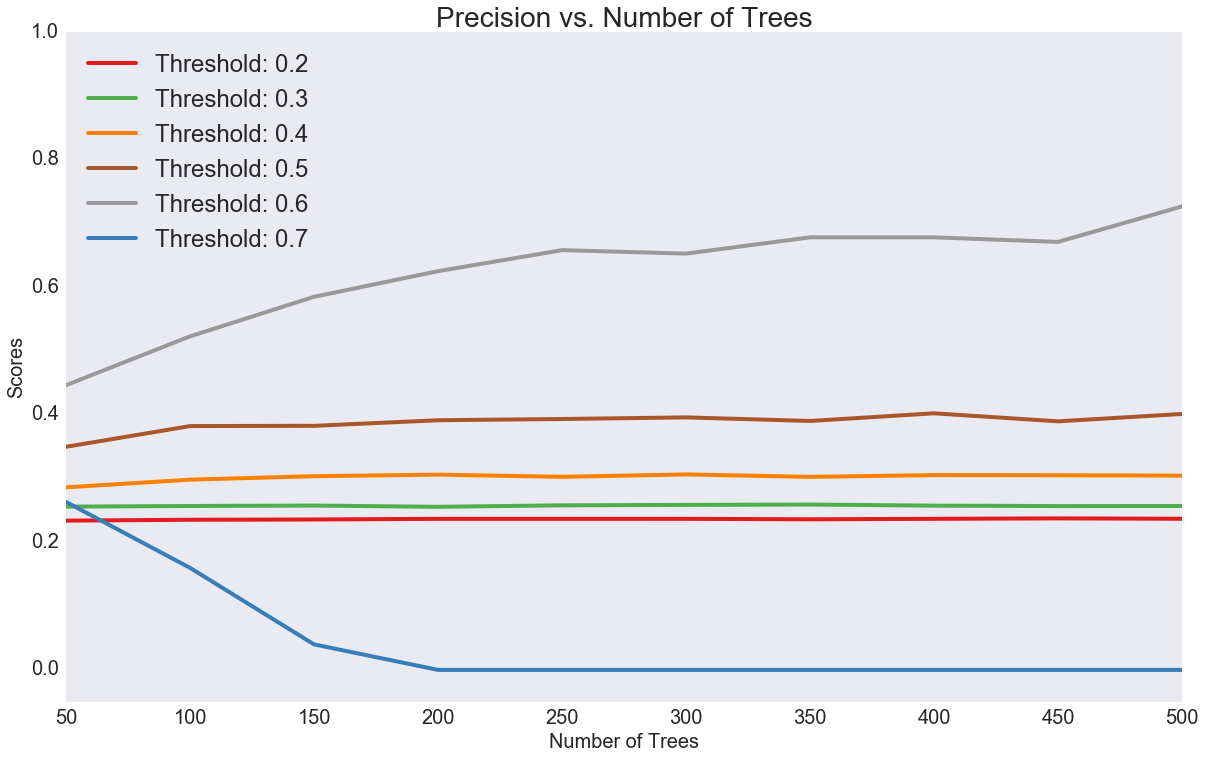

In [196]:
thresholds = np.linspace(0.2, 0.8, 13)
colors = sns.color_palette("Set1", 20)
plt.figure(figsize=(20,12))
plot_index = [0,2,4,6,8,10]
for i in plot_index:
#     tree_avg = np.mean(pre_by_tree_t[i], axis=0)
    
  
    plt.plot(n_trees, pre_tree_mean[i], alpha= 1, lw=4, color=colors[i], label = "Threshold: %.1f"%thresholds[i])

    plt.grid(False)
    plt.legend(loc="upper left", fontsize = 24)
    plt.title("Precision vs. Number of Trees", fontsize = 28)
    plt.xlabel("Number of Trees", fontsize = 20)
    plt.ylabel("Scores", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylim([-0.05,1])

In [ ]:
plt.figure(figsize=(20,12))
for i, tree in enumerate(rec_by_tree):
    tree_avg = np.mean(tree, axis=0)
  
    plt.plot(thresholds, tree_avg, alpha= 0.3, label = "Number of Trees: %10.2f"%thresholds[i])

    plt.grid(False)
    plt.legend(loc="upper left", fontsize = 20)
    plt.title("Precision vs. Threshold", fontsize = 28)
    plt.xlabel("Threshold to Classify as Positive", fontsize = 20)
    plt.ylabel("Scores", fontsize = 20)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)

In [43]:
thresholds = np.linspace(0.2, 0.8, 13)
n_features = np.linspace(1, 13, 13)
n_run=100

pre_by_feature = []
rec_by_feature = []
f_by_feature = []
for n_feature in n_features:
    
    pre_by_run = []
    rec_by_run = []
    f_by_run = []
        
    for i in range(n_run):
        rf_probas = cross_val_predict(rf_proba(n_estimators=200, 
                                               max_features=int(n_feature), 
                                               max_depth=None,
                                               min_samples_split=1,
                                               n_jobs=-1,
                                               warm_start=True,
                                               class_weight = "balanced"),
                                      X_all_rf, Y_all, cv=3)
        

        pre_by_threshold = []
        rec_by_threshold = []
        f_by_threshold = []

        for threshold in thresholds:
            rf_predict = rf_probas[:,1] >= [threshold]*len(rf_probas)
            pre,rec,f = np.array(metrics.precision_recall_fscore_support(Y_all, rf_predict))[:-1,1]
            pre_by_threshold.append(pre)
            rec_by_threshold.append(rec)
            f_by_threshold.append(f)
            
            
        pre_by_run.append(pre_by_threshold)
        rec_by_run.append(rec_by_threshold)
        f_by_run.append(f_by_run)
    
    pre_by_feature.append(pre_by_run)
    rec_by_feature.append(rec_by_run)
    f_by_feature.append(f_by_run)

In [199]:
pre_tree_mean = np.mean(pre_by_feature, axis=1).T
print pre_tree_mean.shape

(13, 13)


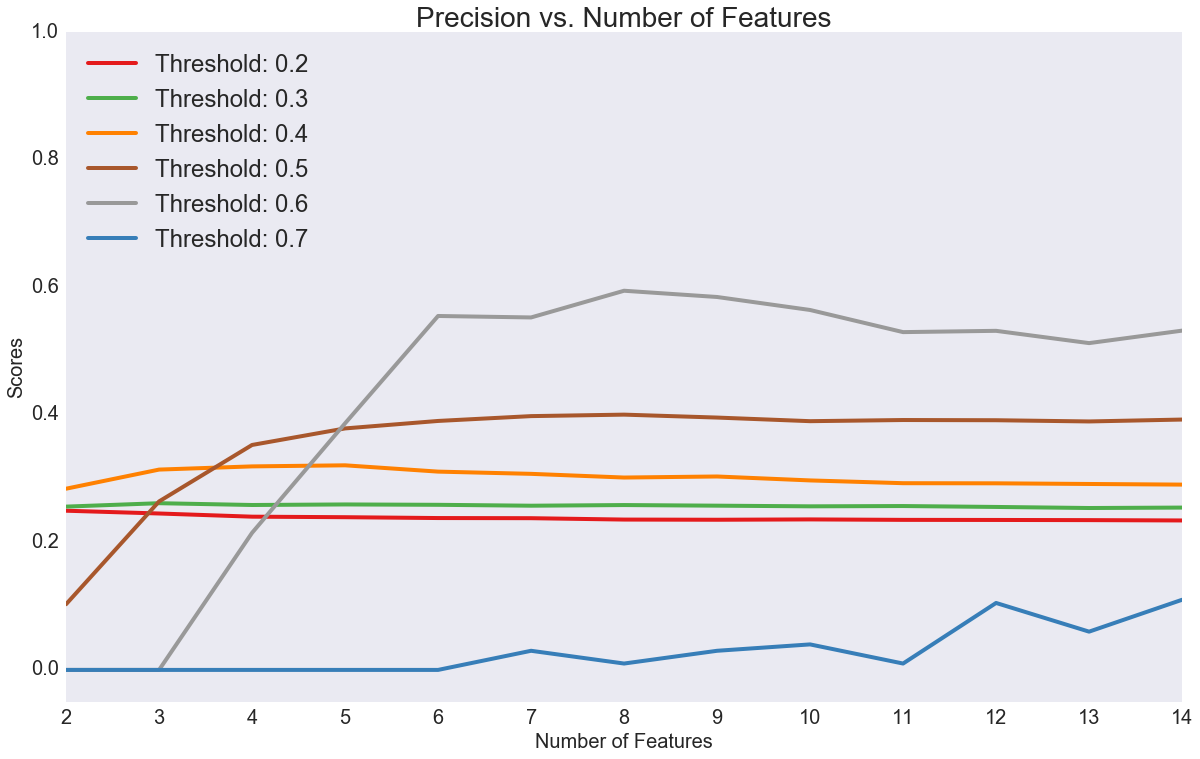

In [211]:
thresholds = np.linspace(0.2, 0.8, 13)
colors = sns.color_palette("Set1", 20)
plt.figure(figsize=(20,12))
plot_index = [0,2,4,6,8,10]
for i in plot_index:
#     tree_avg = np.mean(pre_by_tree_t[i], axis=0)
    
  
    plt.plot(n_features+1, pre_tree_mean[i], alpha= 1, lw=4, color=colors[i], label = "Threshold: %.1f"%thresholds[i])

    plt.grid(False)
    plt.legend(loc="upper left", fontsize = 24)
    plt.title("Precision vs. Number of Features", fontsize = 28)
    plt.xlabel("Number of Features", fontsize = 20)
    plt.ylabel("Scores", fontsize = 20)
    plt.xticks(range(1, 15), fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlim([2, 14])
    plt.ylim([-0.05,1])

In [77]:
thresholds = np.linspace(0.1, 0.8, 15)
n_run=50

pre_all = []
rec_all = []
f_all = []
for threshold in thresholds:
    pre_list = []
    rec_list = []
    f_list = []
    for i in range(n_run):
        rf_probas = cross_val_predict(rf_proba(n_estimators=200, 
                            max_features=7,
                            max_depth=None,
                            min_samples_split=1,
                            n_jobs=-1,
                            warm_start=True,
                            class_weight = "balanced"), X_all_rf, Y_all, cv=3)

        rf_predict = rf_probas[:,1] >= [threshold]*len(rf_probas)
        pre,rec,f = np.array(metrics.precision_recall_fscore_support(Y_all, rf_predict))[:-1,1]
        pre_list.append(pre)
        rec_list.append(rec)
        f_list.append(f)
    pre_all.append(pre_list)
    rec_all.append(rec_list)
    f_all.append(f_list)

(array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9]),
 <a list of 10 Text yticklabel objects>)

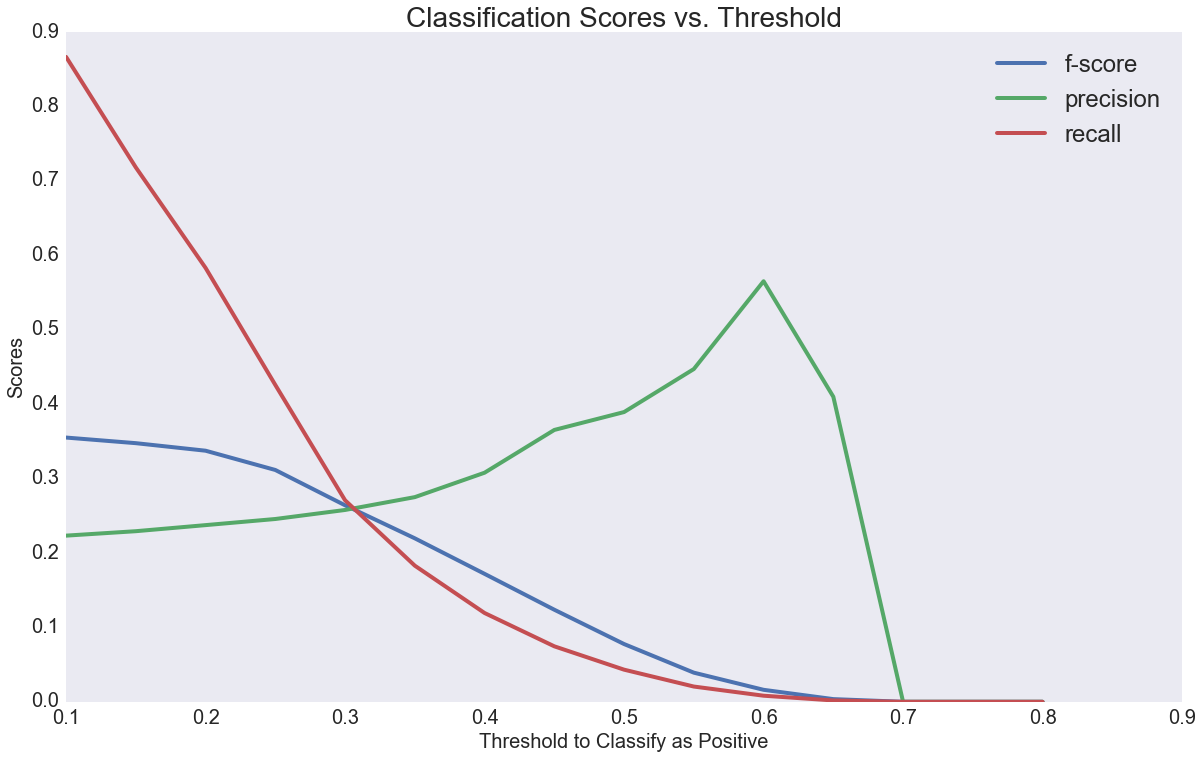

In [80]:
pre_threshold = np.mean(pre_all, axis=1)
rec_threshold = np.mean(rec_all, axis=1)
f_threshold = np.mean(f_all, axis=1)
plt.figure(figsize=(20,12))
plt.plot(thresholds, f_threshold, lw=4, label="f-score")
plt.plot(thresholds, pre_threshold, lw=4, label="precision")
plt.plot(thresholds, rec_threshold, lw=4, label="recall")
plt.grid(False)
plt.legend(fontsize = 24)
plt.title("Classification Scores vs. Threshold", fontsize = 28)
plt.xlabel("Threshold to Classify as Positive", fontsize = 20)
plt.ylabel("Scores", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

### NOW, THE REAL MEAT

In [150]:
def predict_willingness(X, y, param, label_dict, threshold = 0.55, fold=3):
    
    # Fit logistic
    clf_lr = LogisticRegression()
    clf_lr.fit(X, y)
    label_lr = [label_dict[p] for p in param]
    coef_sign = dict(zip(param, ["(-)" if coef<0 else "(+)" for coef in np.sign(np.ravel(clf_lr.coef_))]))
    
    # Fit random forest
    clf_rf = RandomForestClassifier(n_estimators=300, 
                        max_features=8, 
                        max_depth=None,
                        min_samples_split=1,
                        n_jobs=-1,
                        warm_start=True,
                        class_weight = "balanced")
    clf_rf.fit(X, y)
    label_rf = [label_dict[p] for p in param]
    
    # Show precision, recall and f-score
    rf_probas = cross_val_predict(rf_proba(n_estimators=300, 
                    max_features=8, 
                    max_depth=None,
                    min_samples_split=1,
                    n_jobs=-1,
                    warm_start=True,
                    class_weight = "balanced"), X, y, cv=3)
    rf_predict = rf_probas[:,1] >= [threshold]*len(rf_probas)
    print rf_predict
    pre,rec,f,sup = np.array(metrics.precision_recall_fscore_support(y, rf_predict))[:,1]
    print "precision: ", pre
    print "recall: ", rec
    print "f-score: ", f
    print "precdicted positive: ", np.sum(rf_predict)
    print "actual positive: ", np.sum(y)
    
    # Plot feature importance from random forest
    importances = clf_rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
    indices = np.argsort(importances)[::1]
    param_label = [label_rf[ind] + coef_sign[param_rf[ind]] for ind in indices]

    # Plot the feature importances of the forest
    plt.figure(figsize=(20,12))
    plt.barh(range(X.shape[1]), importances[indices], xerr=std[indices], color=["orange"], align="center")
    plt.yticks(range(X.shape[1]), param_label,  fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylabel("Features", fontsize=20)
    plt.xlabel("Importance Score", fontsize=20)
    plt.ylim([-1, X.shape[1]])
    plt.xlim([0,0.25])
    plt.title("Feature Importance", fontsize=28)
    plt.grid(False)
    plt.show()
    
    return pre, rec, f, sup, clf_rf, clf_lr

[False False ..., False False]
precision:  0.454545454545
recall:  0.018115942029
f-score:  0.0348432055749
precdicted positive:  11
actual positive:  276.0


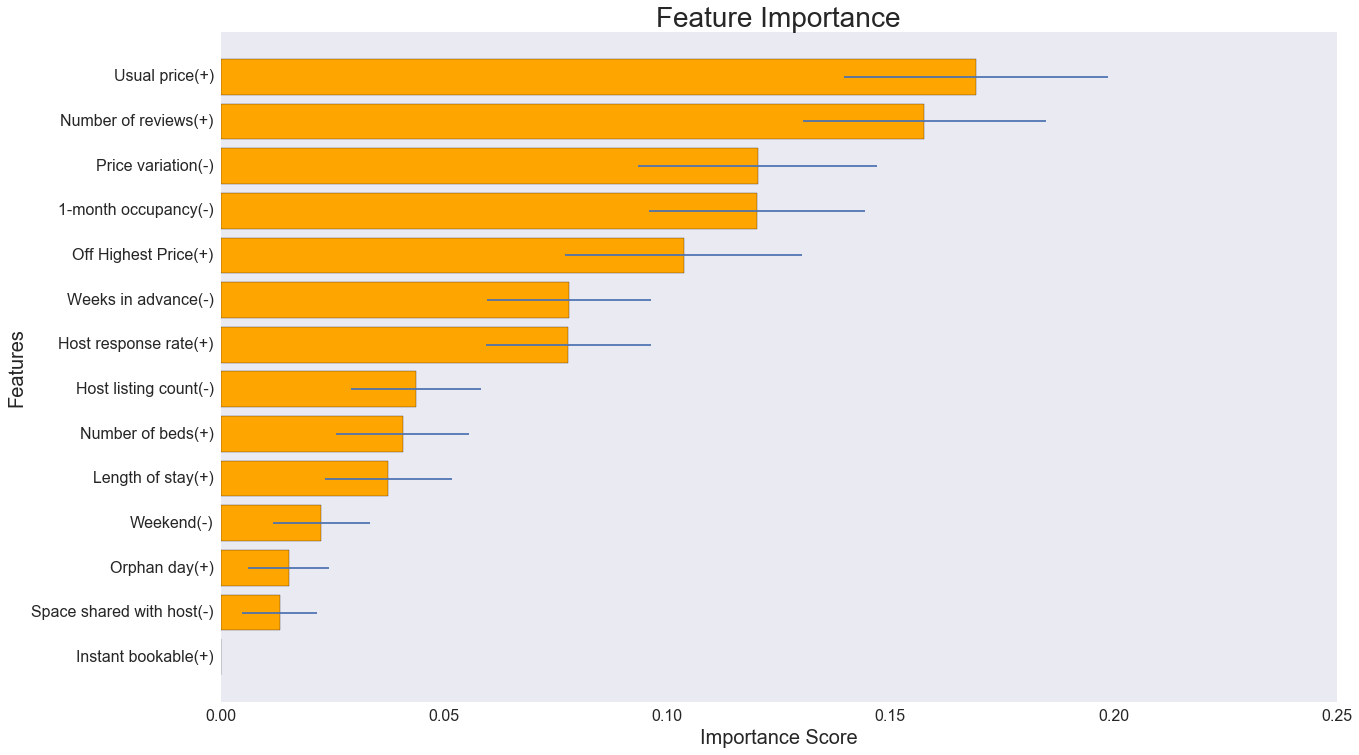

In [151]:
pre, rec, f, sup, clf_rf, clf_lr = predict_willingness(X_all, Y_all, param = param, label_dict = label_dict)

In [170]:
def predict_discount(X, y, param, label_dict, fold=3):
    
    # Fit logistic
    clf_lr = LinearRegression()
    clf_lr.fit(X, y)
    label_lr = [label_dict[p] for p in param]
    coef_sign = dict(zip(param, ["(-)" if coef<0 else "(+)" for coef in np.sign(np.ravel(clf_lr.coef_))]))
    
    # Fit random forest
    clf_rf = RandomForestRegressor(n_estimators=1000, 
                        max_features=14, 
                        max_depth=None,
                        min_samples_split=1,
                        n_jobs=-1,
                        warm_start=True)
    clf_rf.fit(X, y)
#     print param
    label_rf = [label_dict[p] for p in param]
    
    # Show precision, recall and f-score
    rf_predict = cross_val_predict(clf_rf, X, y, cv=fold, n_jobs=-1)
        
#     print zip(y, rf_predict)

    r2 = metrics.r2_score(y, rf_predict)
    rmse = metrics.mean_squared_error(y, rf_predict)
    print "r2: ", r2
    print "mse: ", rmse

    # Plot feature importance from random forest
    importances = clf_rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
    indices = np.argsort(importances)[::1]
    param_label = [label_rf[ind] + coef_sign[param[ind]] for ind in indices]

    # Plot the feature importances of the forest
    plt.figure(figsize=(16,10))
    plt.title("Feature Importance", fontsize=30)
    plt.barh(range(X.shape[1]), importances[indices], xerr=std[indices], color=["orange"], align="center")
    plt.yticks(range(X.shape[1]), param_label,  fontsize=16)
    plt.xticks(fontsize=16)
    plt.ylim([-1, X.shape[1]])
    # plt.xlim([0,0.25])
    plt.grid(False)
    plt.show()
    
    return r2, rmse, clf_rf, clf_lr

r2:  0.0721541941484
mse:  0.00997534928986


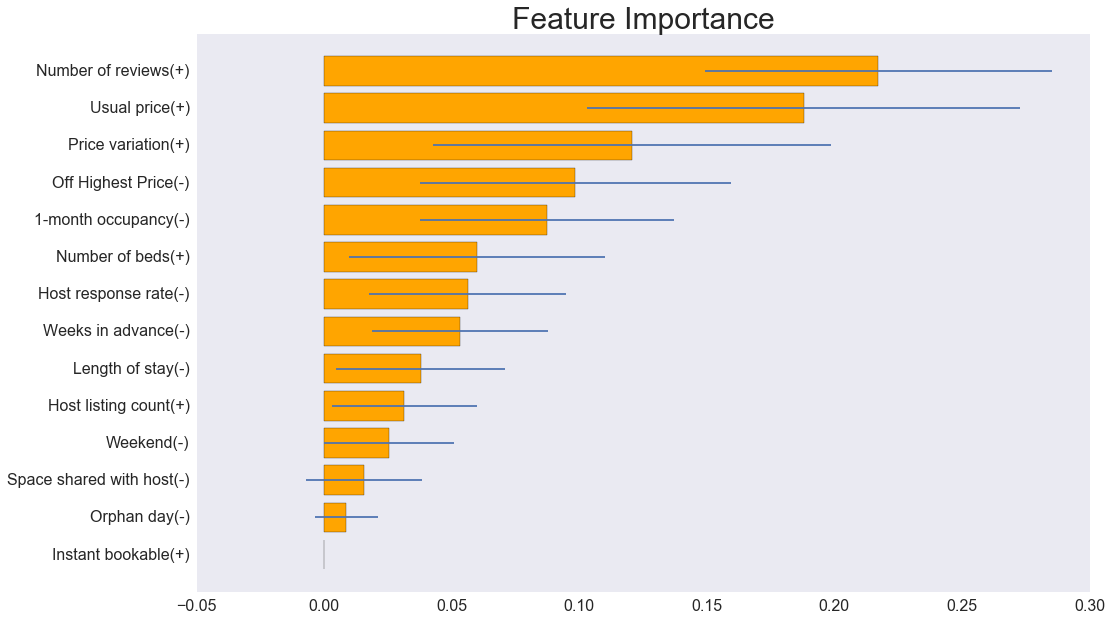

In [171]:
r2, rmse, clf_rf, clf_lr = predict_discount(X_discount, Y_discount, param = param, label_dict = label_dict)

In [93]:
# n_trees = np.linspace(50,500,10)
n_trees = np.linspace(50, 500, 10)
n_run = 100
r2_all = []
for n_tree in n_trees:
    r2_list = []
    clf_rf = RandomForestRegressor(n_estimators=int(n_tree), 
                    max_features=13, 
                    max_depth=None,
                    min_samples_split=1,
                    n_jobs=-1)
    
    for i in range(n_run):
        rf_predict = cross_val_predict(clf_rf, X_discount_rf, Y_discount, cv=3)
        r2 = metrics.r2_score(Y_discount, rf_predict)
#         print r2
        r2_list.append(r2)
    r2_all.append(r2_list)
 


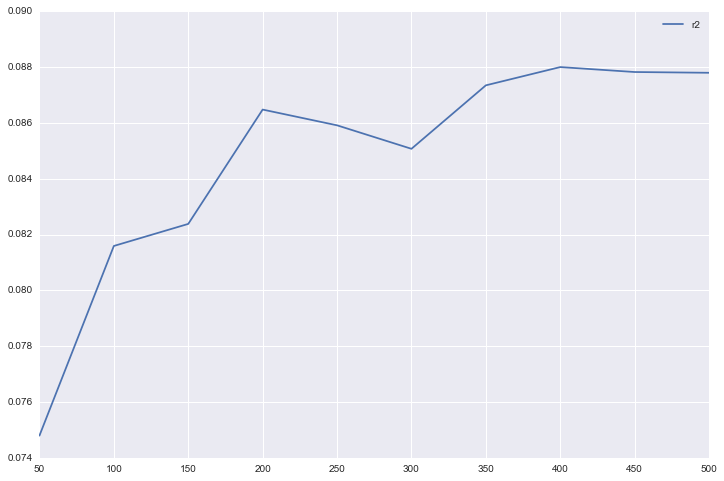

In [94]:
r2_tree = np.mean(r2_all, axis=1)
plt.figure(figsize=(12,8))
plt.plot(n_trees, r2_tree, label="r2")
plt.legend()